In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Classification2D/chest-X-rays/classifier

/content/drive/.shortcut-targets-by-id/1wKSfO3aS4r8zRFUMxOvzXeHIfFXN1QGU/Classification2D/chest-X-rays/classifier


In [3]:
# !nvidia-smi

In [19]:
# !sudo update-alternatives --config python3

In [ ]:
# !python --version

In [20]:
# !sudo apt install python3-pip

In [17]:
# !pip install lungs_segmentation
# !pip install lungmask


In [18]:
!kaggle kernels output eduardomineo/u-net-lung-segmentation-montgomery-shenzhen -p /path/to/dest

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
ModuleNotFoundError: No module named 'kaggle'


In [ ]:
# from lungs_segmentation.pre_trained_models import create_model
from lungmask import mask
import cv2 
import SimpleITK as sitk

img_path = "/content/drive/MyDrive/Classification2D/vinbigdata/data/train/0a01e85a77546c597ca87cd04e922a31.png"

# input_image = cv2.imread(img_path)
# segmentation = mask.apply(input_image)  # default model is U-net(R231)

input_image = sitk.ReadImage(img_path)
# segmentation = mask.apply(input_image)  # default model is U-net(R231)


In [ ]:
print(input_image.shape)
# print(segmentation.shape)

AttributeError: ignored

In [22]:
import os
import shutil
import glob
from typing import List, Union

import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from scipy import ndimage
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
from torch.utils.data import DataLoader as load_batch

import albumentations as A
# from lungs_segmentation.pre_trained_models import create_model

# from segment_lung import SegmentLung
from utils.utils import multiprocess

WORKERS = os.cpu_count()
WORKERS

4

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Classification2D/NIH-Chest-X-ray-Dataset/train_val_data_remain.csv", index_col=0)[10000:12000]
data

In [ ]:
# torch.save(dataset, "/content/drive/MyDrive/Classification2D/chest-X-rays/output/dataset/dataset.pt")


Crop Lung

In [ ]:
# dataset = torch.load("/content/drive/MyDrive/Classification2D/chest-X-rays/output/dataset/dataset.pt")


In [ ]:
import glob
from typing import List, Union

import gc
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from scipy import ndimage
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as load_batch

import albumentations as A
from lungs_segmentation.pre_trained_models import create_model

from utils.utils import get_progress, multiprocess
import itertools
from itertools import chain

class SegmentLung(nn.Module):

    def __init__(self, img_size: int, workers: int, batch_size: int, output_path: str):
        self.output_path = output_path
        self.batch_size = batch_size
        self.workers = workers
        self.img_size = img_size
        self.aug = A.Compose(
            [A.Resize(img_size, img_size, interpolation=1, p=1)], p=1)
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

    def segment(self, model, data, thresh=0.2):
        data_loader_image_path = load_batch(dataset=data["image_path"].values, batch_size=200, num_workers=2) 
        
        for image_path in get_progress(data_loader_image_path, desc="..loading image path.."):
            try:
                dataset = list(map(self.read_one_image, image_path))
                data_loader = load_batch(
                    dataset=dataset, 
                    batch_size=self.batch_size, 
                    num_workers=self.workers
                )
      
            except:
              continue

            else:
                model.eval()
                model.to(self.device)
                for image, image_id in get_progress(data_loader, desc="..loading batch.."):
                    image = image.float().to(self.device)
                    mask = torch.nn.Sigmoid()(model(image))

                    image = image.cpu().detach().numpy()
                    mask = mask.cpu().detach().numpy()
                    mask = (mask > thresh).astype(np.uint8)
                    # merge left and right lung into one
                    mask = np.max(mask, axis=1)[:, np.newaxis]
                    cropped_lung = map(self._crop_one_image_withLCP, mask, image)
                    [np.save(Path(f"{self.output_path}/" + image_id[idc]), lung)
                    for idc, lung in enumerate(cropped_lung)]
                    
                    del mask, image, image_id
            
                del dataset, data_loader
                gc.collect()


    def _crop_one_image_withLCP(self, msk: np.ndarray, img: np.ndarray):
        """This function aims to crop img based on the Largest Connected Component.

        Returns:
            numpy array: A cropped image.
        """
        assert all([(len(msk.shape) == 3), (len(img.shape) == 3)]
                   ), "The input shape must be (depth, height, weight)"
        msk = msk[-2:].squeeze(axis=0)
        img = img[0, ...]
        slice_y, slice_x = ndimage.find_objects(msk, 1)[0]

        h, w = slice_y.stop - slice_y.start, slice_x.stop - slice_x.start
        nw, nh = int(w/0.875), int(h/0.875)
        dw, dh = (nw-w)//2, (nh-h)//2

        top = max(slice_y.start-dh, 0)
        left = max(slice_x.start-dw, 0)
        bot = min(slice_y.stop+dh, 1024)
        right = min(slice_x.stop+dw, 1024)
        img_crop = img[top: bot, left: right]

        # Check whether img size > = 256, if not -> padding
        if np.any(np.array(img_crop.shape[:2]) < self.img_size):
            img_crop = self.pad_image(img=img_crop, axes=(
                0, 1), crop_size=[self.img_size])

        augs = self.aug(image=img_crop)
        cropped_image = augs["image"]
        return cropped_image

    @staticmethod
    def read_one_image(image_path):
          image_id = os.path.basename(image_path).split(".")[0]
          image = cv2.imread(image_path)
          image = (image - image.min()) / (image.max() - image.min())
          image = image.transpose((2, 0, 1))
          image = torch.from_numpy(image)
          return image, image_id

    @classmethod
    def load_unet_model(cls, model_path_or_name: str):
        unet_model = create_model(model_path_or_name)
        return unet_model

    @staticmethod
    def pad_image(img, axes: Union[tuple, list], crop_size: int):
        shapes = np.array(img.shape)
        axes = np.array(axes)
        sizes = np.array(shapes[axes])
        diffs = sizes - np.array(crop_size)

        for diff, axis in zip(diffs, axes):
            left = abs(diff) // 2
            right = (left + 1) if diff % 2 != 0 else left
            if diff >= 0:
                continue
            elif diff < 0:
                img = np.pad(img, [(left, right) if i == axis else (
                    0, 0) for i in range(len(shapes))])
        return img



In [ ]:
model = SegmentLung.load_unet_model("resnet34")

segment_lung = SegmentLung(
    img_size=256, 
    workers=4, 
    batch_size=4, 
    output_path="/content/drive/MyDrive/Classification2D/chest-X-rays/output/lungs-segmentation")

segment_lung.segment(model=model, data=data)


In [ ]:
import glob
import os 
lung_segmentation_path = "/content/drive/MyDrive/Classification2D/chest-X-rays/output/lungs-segmentation"
img_lst= glob.glob("/content/drive/MyDrive/Classification2D/chest-X-rays/output/lungs-segmentation/*")
len(os.listdir(lung_segmentation_path))

(256, 256)


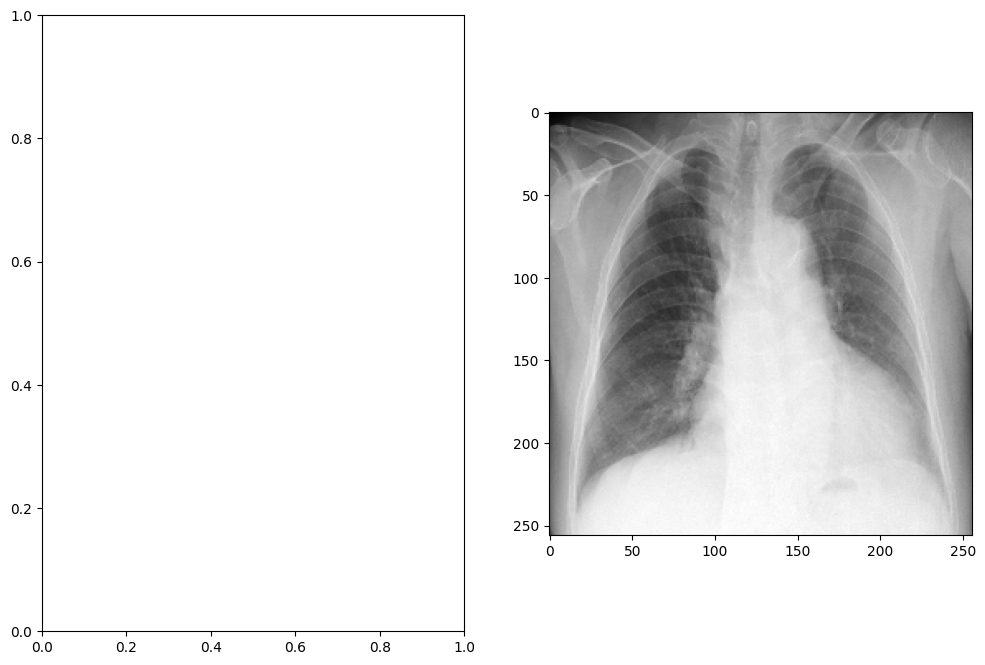

In [24]:
# idc = np.random.choice(len(img_lst))

# random_img, _ = read_one_image(data.loc[idc, "image_path"].values)
# print(random_img.shape)

# random_msk = np.load(img_lst[idc])
random_msk = np.load("/content/drive/MyDrive/Classification2D/chest-X-rays/output/vin-lung-seg/051132a778e61a86eb147c7c6f564dfe.png.npy")

print(random_msk.shape)

_, axes = plt.subplots(1, 2, figsize=(12, 8))
# axes[0].imshow(random_img[0], cmap=plt.cm.gray)
axes[1].imshow(random_msk, cmap=plt.cm.gray)
plt.show()